In [2]:
!pip install einops "tensorflow-text>=2.11"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 85.3 MB/s eta 0:00:00


## Load Library

In [8]:
# data manipulation
import numpy as np

import typing
from typing import Any, Tuple

# Neural network management
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text
# Load datasets
import requests
from zipfile import ZipFile
import polars as pl
import pandas as pd
# Download the file
import pathlib


## Load datasets

In [ ]:
file_name = "spa-eng.zip"

url = f'https://www.manythings.org/anki/{file_name}'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

r = requests.get(url, headers=headers)
# save the file:
with open(file_name, 'wb') as file:
    file.write(r.content)
    
with ZipFile(file_name) as zip_file:
    zip_file.extractall("./spa-eng")

## Clean data

In [ ]:
df = pd.read_csv('spa-eng/spa.txt', sep='\t', header=None)
df.columns = ['eng', 'spa', 'ignore']
df = df[['eng', 'spa']]

df.to_csv('spa-eng/spa.txt', sep='\t', index=False)

In [ ]:
df.describe()

,eng,spa
count,139636,139636
unique,118570,131221
top,You can put it there.,Estoy quebrado.
freq,68,12


In [9]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)
        
            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                            f"Shape mismatch for dimension: '{name}'\n"
                            f"    found: {new_dim}\n"
                            f"    expected: {old_dim}\n"
                    )

In [10]:
path_to_file = pathlib.PosixPath("/content/es-en.parquet")

In [11]:
def load_data(path) -> Tuple[np.ndarray, np.ndarray]:
    """
        Description
        ------------
        This function get the string data from the file path, as the file is 
        tab separated, we split the lines and then split the line with tab

    """
    import polars as pl
    import numpy as np

    df = pl.read_parquet(path)
    df.columns = ['eng', 'spa']
    df = df[['eng', 'spa']]
    
    context = df['spa'].to_numpy()
    target = df['eng'].to_numpy()
    return target, context

In [12]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Mediante la utilización de material de revestimiento poroso, tal como velos o capas tipo piel porosas, se puede inyectar resina en las fibras a través del material de revestimiento, y esto puede ser adicional o alternativo a la inyección central de resina en las fibras.


In [14]:
target_raw, context_raw = load_data(path_to_file)
print(target_raw[-1])

By using porous surfacing material, such as porous veils or peel plies, resin may be injected into the fibres through the surfacing material, and this may be in addition to, or as an alternative to, central injection of resin into the fibres.


In [15]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [16]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Como alternativa, puede ser preferible usar un amplificador operativo configurado como una fuente de corriente controlada por tension, que puede configurarse para permitir que una fuente, o se\xc3\xb1al, de 5 10 15 20 25 30 35 40 45 50 55 60 tension de alta impedancia disponible a partir de un conversor de digital a analogico (DAC) contenido dentro de un microprocesador 140 controle el nivel de corriente que fluye a traves del solenoide o bobina 730.'
 b'Sobre el bastidor 20 est\xc3\xa1 montado unrodillo 23 de aplicaci\xc3\xb3n de etiquetas, el cual forma unaseparaci\xc3\xb3n de agarre con un rodillo 39 que es accionado a lavelocidad de la l\xc3\xadnea, es decir, a una velocidad que se correspondecon la velocidad a la cual son hechos pasar los r\xc3\xb3tulos a trav\xc3\xa9sdel aparato.'
 b'Debe considerarse dentro delalcance de la invenci\xc3\xb3n tener una parte separable (144) que sea unaparte rompible o que pueda usarse un adhesivo o alguna forma desoldadura d\xc3\xa9b

In [17]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [18]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [19]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [20]:
max_vocab_size = 6000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [21]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', 'de', ',', 'la', '.', '[START]', '[END]', 'en', 'el']

In [22]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', ',', '.', 'of', '[START]', '[END]', 'a', 'to']

In [23]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[6, 24, 627, 3, 26, 38, 1125, 342, 12, 2707, 2293, 808, 24, 15, 361, 2,
  227, 1531, 21, 486, 3, 13, 26, 3607, 19, 553, 13, 15, 361, 3, 20, 125, 3,
  2, 486, 2, 249, 3121, 936, 14, 148, 2, 12, 1, 2, 1266, 14, 1, 1, 247, 106,
  2, 12, 3204, 1, 9, 248, 2, 227, 13, 1778, 14, 79, 16, 3692, 20, 1170, 5,
  7]                                                                        ,
 [6, 54, 9, 860, 28, 1230, 1, 2, 343, 2, 2589, 3, 9, 155, 34, 1, 2, 2008,
  18, 12, 773, 13, 23, 2757, 14, 5104, 2, 4, 239, 3, 23, 202, 3, 14, 15,
  229, 13, 11, 1, 4, 229, 14, 4, 155, 41, 3614, 1291, 17, 1, 14, 1, 152, 5,
  7]                                                                       ,
 [6, 333, 3670, 106, 1, 2, 4, 30, 311, 15, 47, 5728, 13, 225, 5798, 1, 20,
  13, 603, 536, 12, 861, 20, 1950, 34, 1, 4286, 3, 44, 24, 1, 3, 19, 1861,
  1, 47, 5728, 10, 9, 5739, 2074, 5, 7]                                   ]>

In [24]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] como alternativa , puede ser preferible usar un amplificador operativo configurado como una fuente de corriente controlada por tension , que puede configurarse para permitir que una fuente , o senal , de tension de alta impedancia disponible a partir de un [UNK] de digital a [UNK] [UNK] contenido dentro de un microprocesador [UNK] el nivel de corriente que fluye a traves del solenoide o bobina . [END]'

Text(0.5, 1.0, 'Mask')

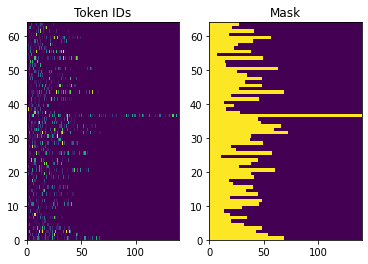

In [25]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [26]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [27]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   6    9   87    2  411    2    1  395 3662    4]

[   6    2   79    5  166    1  716 5234    2 1148]
[   2   79    5  166    1  716 5234    2 1148    5]


In [28]:
UNITS = 256

In [29]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [30]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 94)
Encoder output, shape (batch, s, units): (64, 94, 256)


In [31]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [32]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 94, 256)
Target sequence, shape (batch, t, units): (64, 85, 256)
Attention result, shape (batch, t, units): (64, 85, 256)
Attention weights, shape (batch, t, s):    (64, 85, 94)


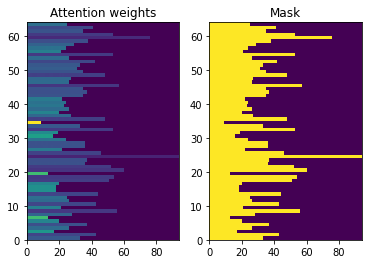

In [33]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [34]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [35]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [36]:
decoder = Decoder(target_text_processor, UNITS)

In [37]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 94, 256)
input target tokens shape: (batch, t) (64, 85)
logits shape shape: (batch, target_vocabulary_size) (64, 85, 6000)


In [38]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [39]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [40]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [41]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'inks balloon reconstituted enzymes vice w acute withstand liposome resilient',
       b'pulmonary wearer centre gap brine on schematically vent celite nitrile',
       b'th penetrating spherical rotates induced densities appended rf payment primary'],
      dtype=object)

In [42]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [43]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 94)
Target tokens, shape: (batch, t) (64, 85)
logits, shape: (batch, t, target_vocabulary_size) (64, 85, 6000)


In [44]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [45]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [46]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [47]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.699514, 'expected_acc': 0.00016666666666666666}

In [48]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 35s 1s/step - loss: 8.7106 - masked_acc: 0.0012 - masked_loss: 8.7106


{'loss': 8.710596084594727,
 'masked_acc': 0.001193295931443572,
 'masked_loss': 8.710596084594727}

In [49]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 343s 3s/step - loss: 5.9137 - masked_acc: 0.1352 - masked_loss: 5.9137 - val_loss: 5.1616 - val_masked_acc: 0.2304 - val_masked_loss: 5.1616
Epoch 2/100
100/100 [==============================] - 342s 3s/step - loss: 4.8197 - masked_acc: 0.2610 - masked_loss: 4.8197 - val_loss: 4.6194 - val_masked_acc: 0.2750 - val_masked_loss: 4.6194
Epoch 3/100
100/100 [==============================] - 338s 3s/step - loss: 4.4629 - masked_acc: 0.2902 - masked_loss: 4.4629 - val_loss: 4.3129 - val_masked_acc: 0.3001 - val_masked_loss: 4.3129
Epoch 4/100
100/100 [==============================] - 339s 3s/step - loss: 4.1810 - masked_acc: 0.3203 - masked_loss: 4.1810 - val_loss: 4.0410 - val_masked_acc: 0.3337 - val_masked_loss: 4.0410
Epoch 5/100
100/100 [==============================] - 354s 4s/step - loss: 3.8282 - masked_acc: 0.3646 - masked_loss: 3.8282 - val_loss: 3.6761 - val_masked_acc: 0.3865 - val_masked_loss: 3.6761
Epoch 6/100
100/100 

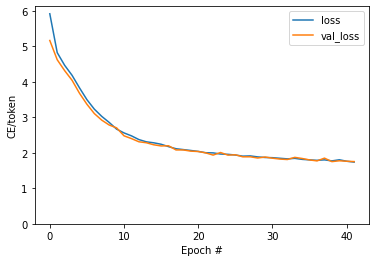

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

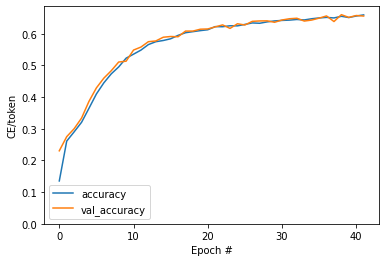

In [51]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [52]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [53]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'it is still in [UNK] [UNK] '

In [54]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-54-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-54-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


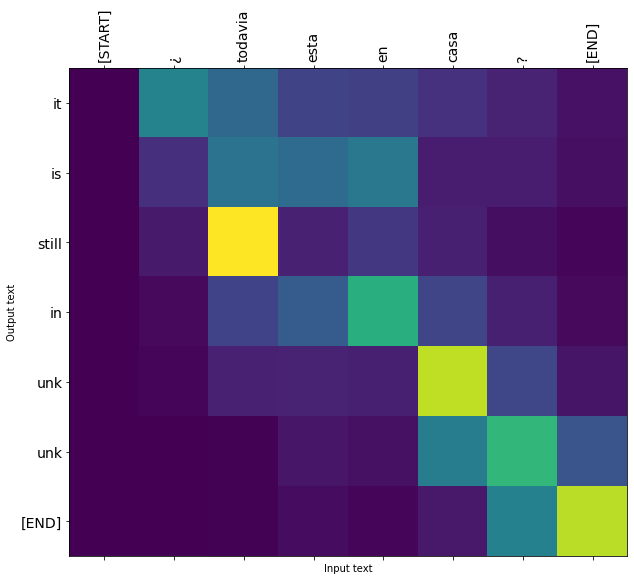

In [55]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

<ipython-input-54-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-54-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 231 ms, sys: 2.01 ms, total: 233 ms
Wall time: 232 ms


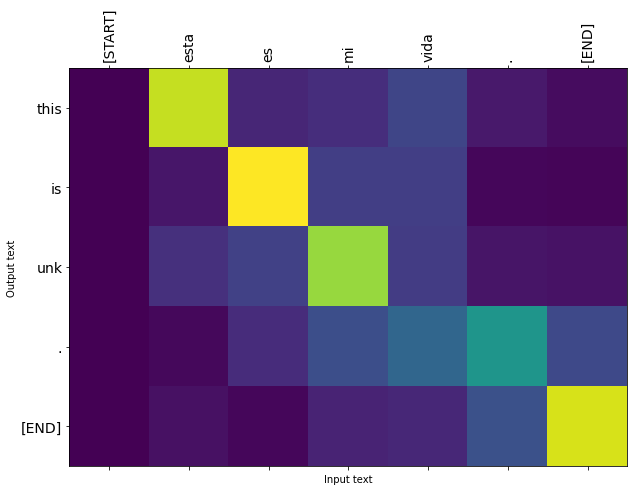

In [56]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

<ipython-input-54-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-54-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 197 ms, sys: 1.99 ms, total: 199 ms
Wall time: 205 ms


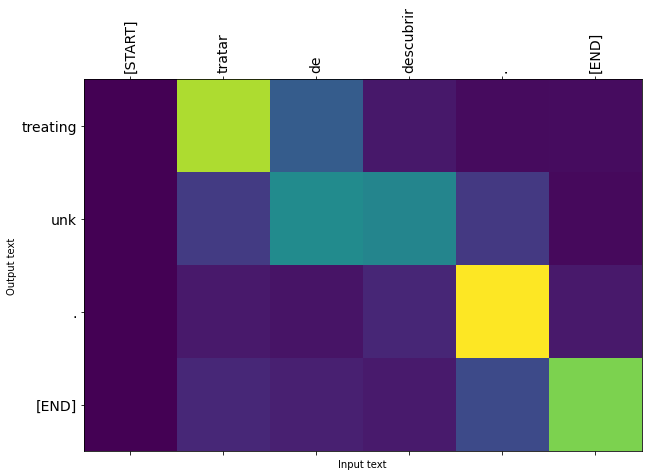

In [57]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

In [58]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 By using porous surfacing material, such as porous veils or peel
plies, resin may be injected into the fibres through the surfacing
material, and this may be in addition to, or as an alternative to,
central injection of resin into the fibres.


<ipython-input-54-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-54-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


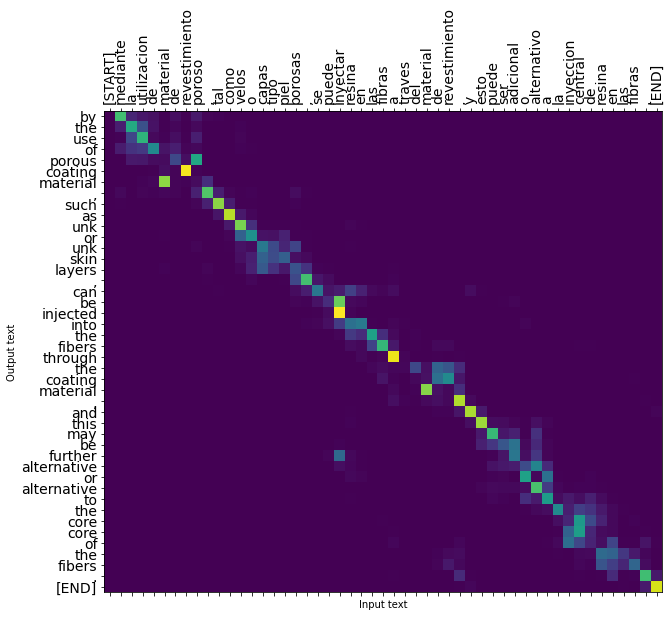

In [59]:
model.plot_attention(long_text)

In [60]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.', # "His room is a mess"
    'Hola ¿Cómo estas?',
    'El jueves estuve en Bogota, fue una gran experiencia.',
    'Juan, Caleb y yo estuvimos nerviosos.',
    "Me gustaria saber como funcionas."
]

In [61]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

cold spring is cold here . 
this is [UNK] . 
its fourth is a [UNK] . 
as these [UNK] are also provided in such a manner as well as the [UNK] 
the [UNK] [UNK] [UNK] was a great experience . 
[UNK] , [UNK] and [UNK] [UNK] . 
[UNK] [UNK] i as [UNK] . 

CPU times: user 2.07 s, sys: 22 ms, total: 2.09 s
Wall time: 2.1 s
